In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import pearsonr, spearmanr

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [107]:
df = pd.read_csv(
    "ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt500_numgenerations100_ancestral_scoredreward_scorednll.csv"
)
df["generated_text"] = df.apply(
    lambda row: row["generated_text"][len(row["prompt"]) :], axis=1
)
df["log_probability"] = -df["negative_log_probability"]

df = df.drop_duplicates()
df.head()

,prompt,generated_text,score,negative_log_probability,log_probability
0,Can you give me facts about jumping spiders?,"How are they different from other spiders, like the orb weavers? Are there a lot of them? Are they dangerous? How many different kinds of jumping spiders are there in North America? What are the ones that I'm most likely to encounter, and what kinds of behavior can I expect from them? Also, why are they called jumping spiders?",2.556192,150.421768,-150.421768
1,Can you give me facts about jumping spiders?,\nMost jumping spiders are under 1.5 cm in length. The most common and recognizable jumping spiders are black with brown markings. They have very large eyes that are at the top of their head. The chelicerae (fangs) of a jumping spider are the largest relative to its body size compared to other spiders.,1.860381,145.223724,-145.223724
2,Can you give me facts about jumping spiders?,"\nYes! The first thing you should know is that jumping spiders are not actually spiders, they are arachnids, like the much more common house spiders. The second thing you should know is that many jumping spiders have great vision. Many species have color vision, and most can see in ultraviolet, which helps them find prey that is hiding in the dark. Most species also have excellent night vision.",1.704642,163.032410,-163.032410
3,Can you give me facts about jumping spiders?,"I want to know more about their habitat, their life cycle, and their diet, and if they bite, what kind of symptoms can I expect. Also, I’d like to know more about how they hunt and what prey they capture. I’m more scared of them than scared of spiders in general, so I want to learn more to help me manage my fear of them.",2.186887,182.907928,-182.907928
4,Can you give me facts about jumping spiders?,"\nThere are many facts about jumping spiders! They have 8 eyes, including 2 large front eyes and 2 small side eyes. They use their front legs to jump. Female jumping spiders have an additional pedipalp, a modified front leg with a claw on the end. The pedipalp has a reproduction organ, a swelling on the end called a palp, that is used to transfer sperm to the female’s genital opening. The palp is also used to transfer sperm to the egg sac, which the female carries on her back. Female jumping spiders have a special silk gland at the end of the abdomen that produces egg sacs.",0.779371,253.502426,-253.502426


In [108]:
df[["score", "negative_log_probability", "log_probability"]].describe()

,score,negative_log_probability,log_probability
count,37118.000000,37118.000000,37118.000000
mean,3.719565,184.563828,-184.563828
std,1.905796,115.071172,115.071172
min,-7.811958,16.909975,-585.668762
25%,2.636159,91.682365,-258.422318
50%,3.777733,152.717247,-152.717247
75%,4.800403,258.422318,-91.682365
max,20.260225,585.668762,-16.909975


In [109]:
num_corpuses = 1000
num_samples_per_corpus = 100_000

In [110]:
# 1. Sample corpuses
corpuses = dict()
for corpus_seed in range(num_corpuses):
    corpus = df.sample(num_samples_per_corpus, random_state=corpus_seed, replace=True)
    corpuses[corpus_seed] = corpus

# 2. Compute sample level correlation between score and nll
spearman_correlations = {
    corpus_seed: spearmanr(corpus["score"], corpus["log_probability"])
    for corpus_seed, corpus in corpuses.items()
}
pearson_correlations = {
    corpus_seed: pearsonr(corpus["score"], corpus["log_probability"])
    for corpus_seed, corpus in corpuses.items()
}
# 2.1 print
print("!!!!! Sample level !!!!!")
print(
    "Average spearman ="
    f" {sum([x.correlation for x in spearman_correlations.values()]) / num_corpuses},"
    " SE ="
    f" {np.std([x.correlation for x in spearman_correlations.values()]) / np.sqrt(num_corpuses)}"
)
print(
    "Average pearson ="
    f" {sum([x[0] for x in pearson_correlations.values()]) / num_corpuses}, SE ="
    f" {np.std([x[0] for x in pearson_correlations.values()]) / np.sqrt(num_corpuses)}"
)

# 3. Compute corpus level correlation between score and nll (blind)
mean_corpuses = pd.DataFrame.from_dict({
    corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
    for corpus_seed, corpus in corpuses.items()
}).T

print("!!!!! Corpus level (blind) !!!!!")
print(
    "Average spearman ="
    f" {spearmanr(mean_corpuses['score'], mean_corpuses['log_probability']).correlation}"
)
print(
    "Average pearson ="
    f" {pearsonr(mean_corpuses['score'], mean_corpuses['log_probability'])[0]}"
)
mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
)
plt.show()
plt.close()

!!!!! Corpus level (binned) !!!!!
Average spearman = 0.5878787878787878
Average pearson = 0.5308655228194301


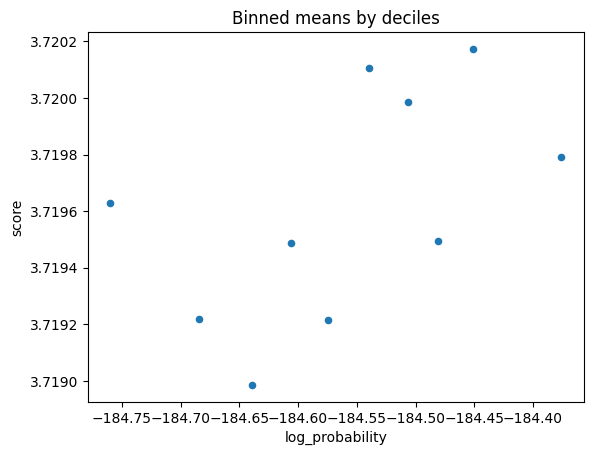

In [ ]:
print("!!!!! Corpus level (binned) !!!!!")
mean_corpuses["score_bin"] = pd.qcut(
    mean_corpuses["score"], num_corpuses // 100, labels=False
)
mean_corpuses["p_bin"] = pd.qcut(
    mean_corpuses["log_probability"], num_corpuses // 100, labels=False
)
mean_binned_means = mean_corpuses.groupby(["p_bin"]).mean().reset_index()
print(
    "Average spearman ="
    f" {spearmanr(mean_binned_means['score'], mean_binned_means['log_probability']).correlation}"
)
print(
    "Average pearson ="
    f" {pearsonr(mean_binned_means['score'], mean_binned_means['log_probability'])[0]}"
)


mean_binned_means.plot.scatter(
    y="score",
    x="log_probability",
    title="Binned means by deciles",
)
plt.show()
plt.close()

In [69]:
num_bins = 10


df_binned = df.copy()
df_binned["score_bin"] = pd.qcut(df_binned["score"], num_bins, labels=False)
df_binned["p_bin"] = pd.qcut(df_binned["log_probability"], num_bins, labels=False)
df_binned.head()

,prompt,generated_text,score,negative_log_probability,log_probability,score_bin,p_bin
0,Can you give me facts about jumping spiders?,I’m doing a research project and I would really appreciate it if you could help me!,3.740791,62.446930,-62.446930,3,7
1,Can you give me facts about jumping spiders?,,7.458329,36.092606,-36.092606,8,9
2,Can you give me facts about jumping spiders?,What kinds of things do they eat? What sorts of things might eat them? How big do they get? Are they dangerous to humans? Are they dangerous to cats? Are they dangerous to birds? What do they look like? What do they sound like? What are their mating behaviors? What do their webs look like? Are their webs sticky? How many different kinds of jumping spiders are there? Where do they live? Are they only found in the Americas? Are they only found in Australia? Are they only found in the Pacific Rim? Are they only found in the Western Hemisphere? Are they only found in Central America? Are they only found in South America? Are they only found in Africa? Are they only found in Asia? Are they only found in Europe? Are they only found in the Mediterranean Basin? Are they only found in the Pacific Ocean? Are they only found in the Atlantic Ocean? Are they only found in the Indian Ocean? Are they only found in the Southern Ocean? Are they,3.565451,221.093109,-221.093109,3,2
3,Can you give me facts about jumping spiders?,"\nA. Sure, they are one of the largest families of spiders, and are found all over the world. Jumping spiders have very large, complex eyes. They are able to jump by using an unusual spinneret at the end of their abdomen to propel themselves through the air. Many jumping spiders have stripes or other markings on their bodies and often have the ability to change colors. They are usually active during the day.",1.690397,172.173767,-172.173767,0,3
4,Can you give me facts about jumping spiders?,,7.458329,36.092606,-36.092606,8,9


!!!!! Corpus level (binned) !!!!!
Average spearman = 0.7975787077727543
Average pearson = 0.6355938708602217


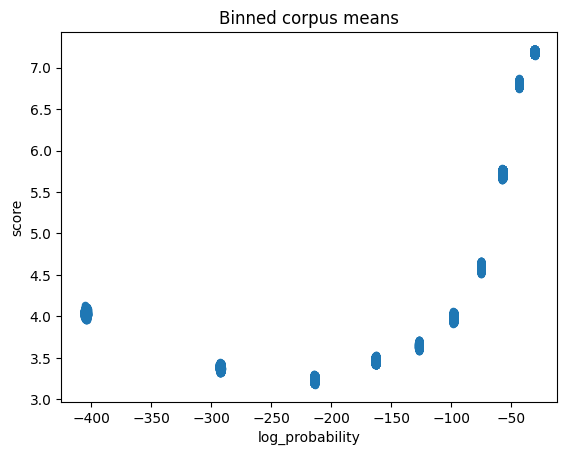

In [76]:
corpuses_binned = dict()
for corpus_seed in range(num_corpuses):
    random_bin = np.random.randint(0, num_bins)
    corpus = df_binned[df_binned["p_bin"] == random_bin].sample(
        num_samples_per_corpus, random_state=corpus_seed, replace=True
    )
    corpuses_binned[corpus_seed] = corpus

mean_binned_corpuses = pd.DataFrame.from_dict({
    corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
    for corpus_seed, corpus in corpuses_binned.items()
}).T
print("!!!!! Corpus level (binned) !!!!!")
print(
    "Average spearman ="
    f" {spearmanr(mean_binned_corpuses['score'], mean_binned_corpuses['log_probability']).correlation}"
)
print(
    "Average pearson ="
    f" {pearsonr(mean_binned_corpuses['score'], mean_binned_corpuses['log_probability'])[0]}"
)
mean_binned_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Binned corpus means",
)
plt.show()
plt.close()

In [72]:
df["negative_log_probability"].mean(axis=0)

150.47319913726807